In [1]:
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, roc_curve, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout, MaxPool2D, Conv2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

tf.__version__

'2.3.1'

In [2]:
cwd = os.getcwd()
DATA_LIST = os.listdir(cwd + '/train')
TRAIN_DIR  = cwd + '/train'
TEST_DIR = cwd + '/test'
IMAGE_SIZE = (50, 50)
BATCH = 32 #10  
EPOCHS = 30
LR = 0.00001 

## Data Pre-Processing

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   validation_split = 0.2)


train_batches = train_datagen.flow_from_directory(TRAIN_DIR,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(TRAIN_DIR,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH,
                                                  subset = "validation",
                                                  seed=42,class_mode="binary")


Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## CNN Architecture

In [6]:
model = Sequential()
model.add(Conv2D(16, (3, 3), name='conv2d_1', activation='relu', input_shape=(50,50,3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())          

model.add(Conv2D(32, (3, 3), name='conv2d_2', activation='relu'))
model.add(MaxPool2D(2,2)) 
model.add(BatchNormalization())          

model.add(Conv2D(64, (3, 3), name='conv2d_3', activation='relu'))
model.add(MaxPool2D(2,2)) 
model.add(BatchNormalization()) 

model.add(Flatten())
model.add(Dense(64,activation="relu",name="dense_"))
model.add(Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 16)        448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 11, 11, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)         

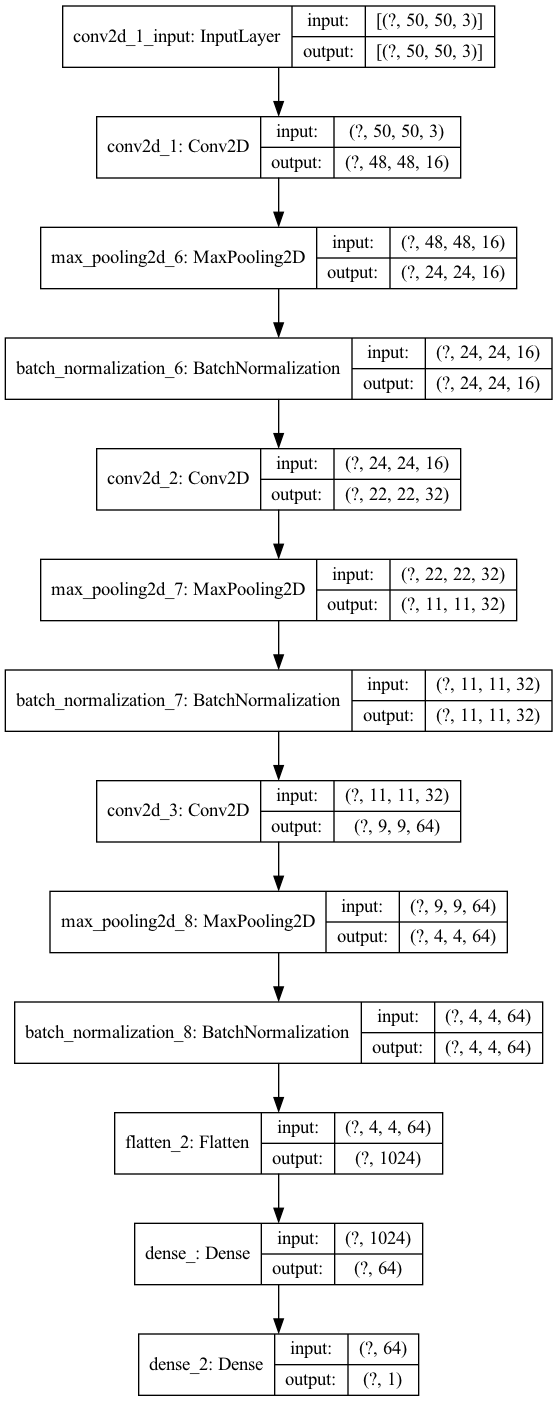

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)

## CNN Training

In [8]:
print(len(train_batches))
print(len(valid_batches))

STEP_TRAIN=train_batches.n//train_batches.batch_size
STEP_VALID=valid_batches.n//valid_batches.batch_size

opt = tf.keras.optimizers.Adam(learning_rate=LR)

model.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=['accuracy'])

history = model.fit(train_batches, 
                    steps_per_epoch=STEP_TRAIN, 
                    epochs=EPOCHS, 
                    validation_data=valid_batches, 
                    validation_steps=STEP_VALID)


100
25
Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 99/100 [============================>.] - ETA: 0s - loss: 0.1618 - accuracy: 0.9801WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f84f0bc88c0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=

## Training Results

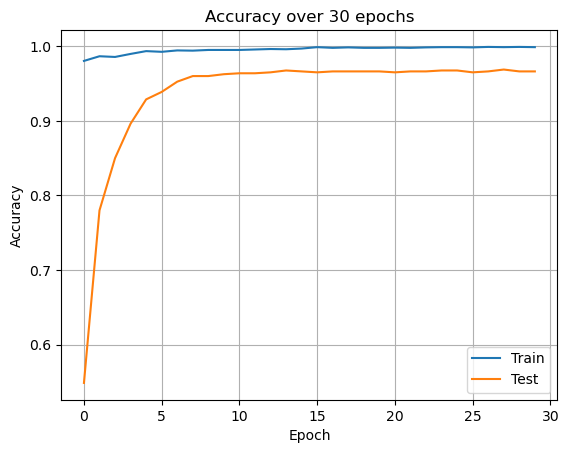

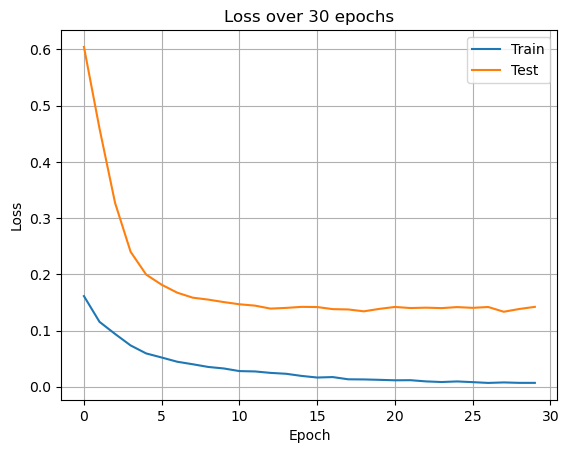

In [9]:
plt.figure(1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label = 'Test')
plt.title("Accuracy over " + str(EPOCHS) + " epochs")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()


plt.figure(2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label = 'Test')
plt.title("Loss over " + str(EPOCHS) + " epochs")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()

plt.show()

## Testing

In [8]:
# model.load('../model/henry_model.h5')
model = tf.keras.models.load_model('../model/henry_model.h5')

In [14]:
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image


test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=to_grayscale_then_rgb)
test_batches = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")

test_batches.reset()
print(len(test_batches))
model_eval = model.evaluate(test_batches,steps = np.ceil(len(test_batches)),verbose = 1)
print('Test loss:' , model_eval[0])
print('Test accuracy:',model_eval[1])

Found 1452 images belonging to 2 classes.
dict_keys(['Closed_Eyes', 'Open_Eyes'])
1452
1452/1452 [==============================] - 6s 4ms/step - loss: 0.3014 - accuracy: 0.8850
Test loss: 0.30139026045799255
Test accuracy: 0.8849862217903137


## Testing Performance

In [10]:
y_pred_probs = model.predict(test_batches,steps = np.ceil(len(test_batches)),verbose = 1)
y_preds = y_pred_probs >= 0.5
y_labels = test_batches.labels
labels_class = ["Closed Eyes", "Open Eyes"]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1452/1452 [==============================] - 5s 4ms/step


### Confusion Matrix

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


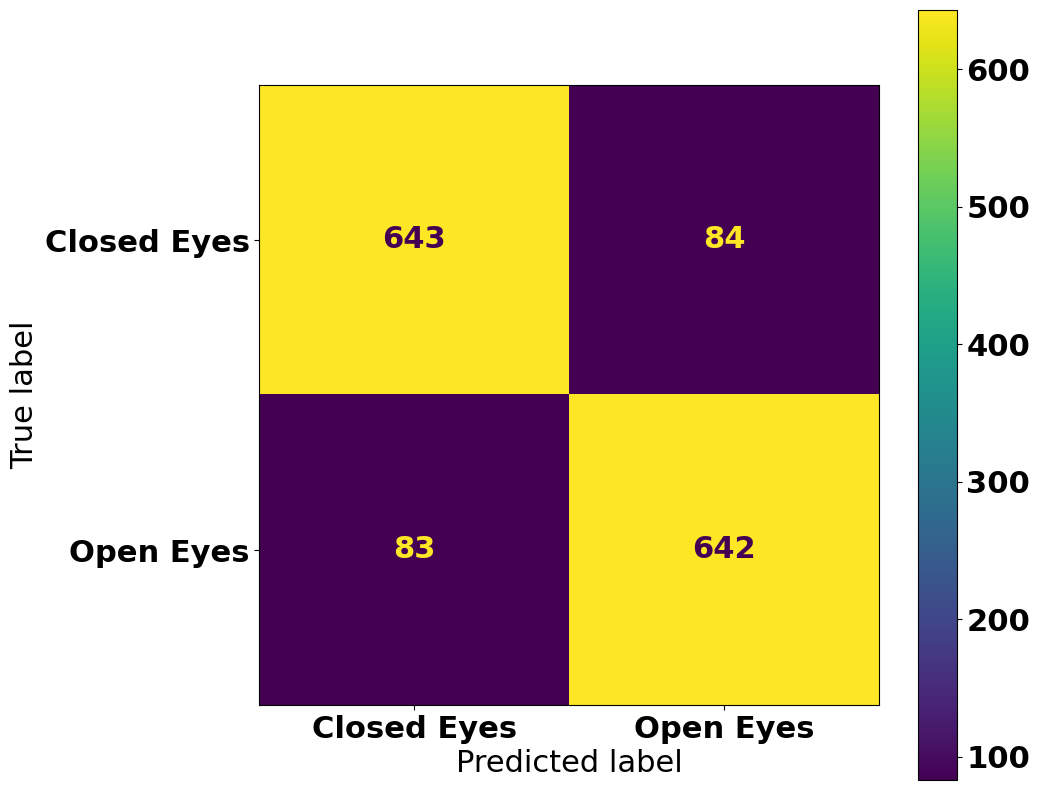

In [11]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}
plt.rc('font', **font)

cm=confusion_matrix(y_preds,y_labels)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels_class)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

### ROC Curve

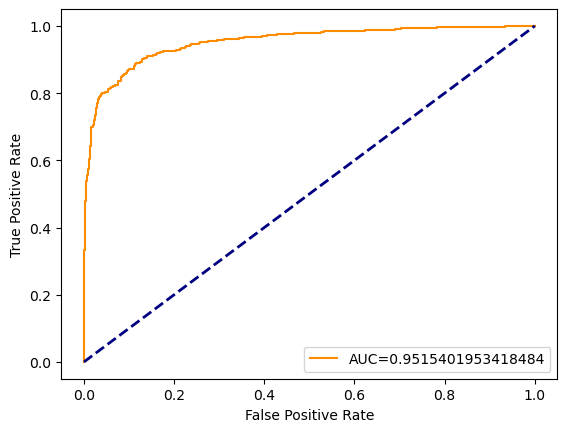

In [11]:
fpr, tpr, _ = metrics.roc_curve(y_labels,  y_pred_probs)
auc = metrics.roc_auc_score(y_labels, y_pred_probs)

plt.plot(fpr,tpr,label="AUC="+str(auc),color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [13]:
print('Precision: %.3f' % precision_score(y_labels, y_preds))
print('Recall: %.3f' % recall_score(y_labels, y_preds))
print('F1 Score: %.3f' % f1_score(y_labels, y_preds))

Precision: 0.886
Recall: 0.884
F1 Score: 0.885
